# Lemniscate Snapshot Utilities Demo

This notebook builds a lemniscate (∞) factor graph, runs a single PropFlow engine execution with snapshots enabled, and exercises the snapshot utilities and visualisation helpers end-to-end.

In [8]:
from __future__ import annotations

from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np

from propflow import SnapshotAnalyzer, AnalysisReport, SnapshotVisualizer
from propflow.bp.engine_base import BPEngine
from propflow.configs import create_random_int_table
from propflow.snapshots.types import SnapshotsConfig
from propflow.snapshots.utils import (
    latest_snapshot,
    latest_jacobians,
    latest_cycles,
    latest_winners,
    get_snapshot,
)
from propflow.utils.fg_utils import FGBuilder

In [9]:
np.random.seed(7)

RUN_DIR = Path("results/notebooks/lemniscate_all_utils")
RUN_DIR.mkdir(parents=True, exist_ok=True)

snapshot_cfg = SnapshotsConfig(
    compute_jacobians=True,
    compute_block_norms=True,
    compute_cycles=True,
    include_detailed_cycles=True,
    compute_numeric_cycle_gain=False,
    retain_last=None,
    save_each_step=False,
)

graph = FGBuilder.build_lemniscate_graph(
    num_vars=8,
    domain_size=3,
    ct_factory=create_random_int_table,
    ct_params={"low": 1, "high": 7},
)

engine = BPEngine(
    factor_graph=graph,
    snapshots_config=snapshot_cfg,
    use_bct_history=True,
)


In [10]:
MAX_STEPS = 10
engine.run(max_iter=MAX_STEPS)
manager = engine._snapshot_manager
captured_steps = list(range(len(engine.history.step_costs)))
print(f"Captured {len(captured_steps)} steps; final step = {captured_steps[-1]}")


Captured 10 steps; final step = 9


In [11]:
latest = latest_snapshot(engine)
print("Latest snapshot step:", latest.data.step)

jac = latest_jacobians(engine)
print("Jacobian blocks available:", jac is not None)
if jac and jac.block_norms:
    print("Block norms:", jac.block_norms)

cycles = latest_cycles(engine)
print("Cycle metrics:", cycles.num_cycles if cycles else None)

winners = latest_winners(engine)
print("Winner entries:", len(winners) if winners else 0)

first_step = captured_steps[0]
first_rec = get_snapshot(engine, first_step)
print("First step Q messages:", list(first_rec.data.Q.keys())[:3])


Latest snapshot step: 9
Jacobian blocks available: True
Block norms: {'||BPA||_inf': 6.0, '||B||_inf': 0.0, '||PA||_inf': 6.0, '||M||_inf_upper': 6.0}
Cycle metrics: 3
Winner entries: 54
First step Q messages: [('x4', 'f34'), ('x4', 'f41'), ('x5', 'f15')]


In [12]:
last_step = captured_steps[-1] # type: ignore
step_dir = manager.save_step(last_step, RUN_DIR, save=True) # type: ignore
print("Persisted step directory:", step_dir)
meta = json.loads((step_dir / "meta.json").read_text())
meta["context"]


Persisted step directory: results/notebooks/lemniscate_all_utils/step_0009


{'step': 9, 'lambda': 0.0, 'timestamp': '2025-10-26T23:54:26.670664+00:00'}

In [13]:
snapshots = [get_snapshot(engine, step) for step in captured_steps]
analyzer = SnapshotAnalyzer(snapshots)
report = AnalysisReport(analyzer)
summary = report.to_json(step_idx=captured_steps[-1])
summary_keys = sorted(summary.keys())
print("Analysis report keys:", summary_keys)
summary["block_norms"]

Analysis report keys: ['beliefs', 'block_norms', 'cycle_metrics', 'nilpotent_index', 'spectral_radius', 'step']


/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/analyzer.py:229: RuntimeWarning: divide by zero encountered in matmul
  power = power @ dense
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/analyzer.py:229: RuntimeWarning: overflow encountered in matmul
  power = power @ dense
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/analyzer.py:229: RuntimeWarning: invalid value encountered in matmul
  power = power @ dense


{'A': 3.0, 'B': 1.0, 'P': 0.0}

Variables: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
Series tracked for 8 variables


/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:159: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  combined_fig.show()
/Users/or/Projects/Belief-Propagation-Simulator/src/propflow/snapshots/visualizer.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  per_var_fig.show()


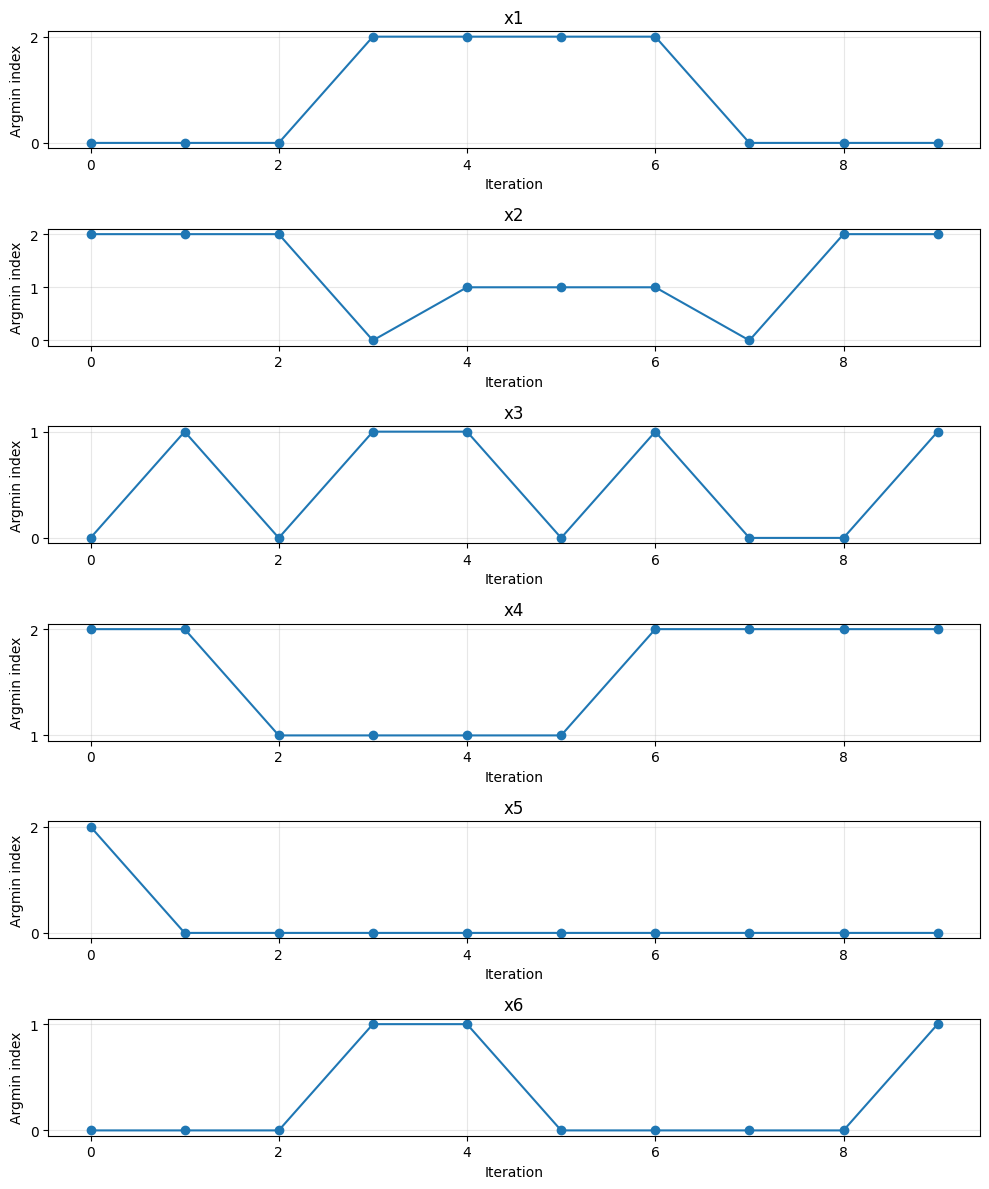

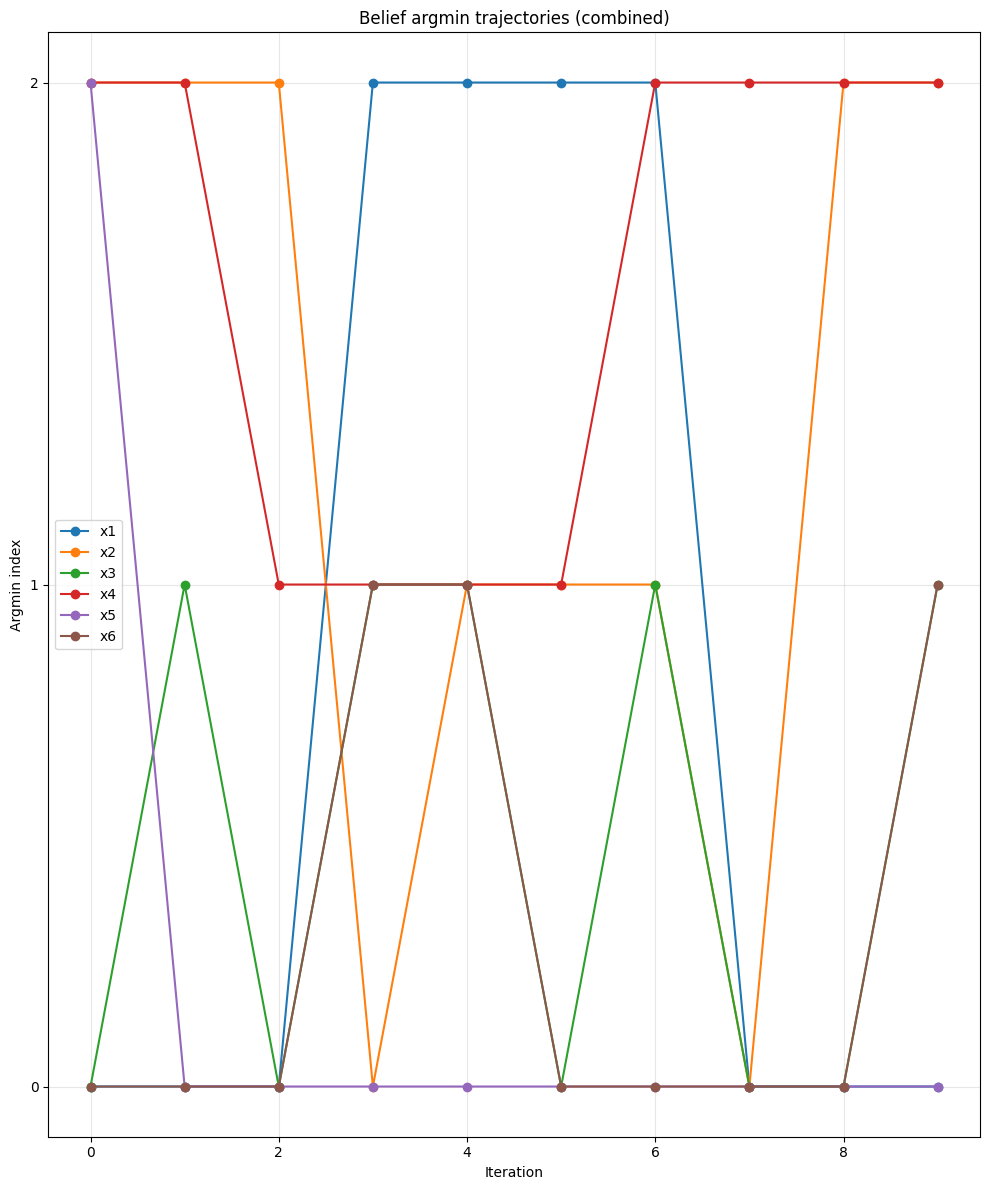

hi


In [14]:
visualizer = SnapshotVisualizer(snapshots)
print("Variables:", visualizer.variables())
series = visualizer.argmin_series()
print("Series tracked for", len(series), "variables")

visualizer.plot_argmin_per_variable(vars_filter=visualizer.variables()[:6], figsize=(10, 12))
plt.show()
print("hi")